In [7]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
from utils import *
import random
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [8]:
# Original graph setup
G_original = nx.DiGraph()
G_original.add_nodes_from(["Attacker", "Data Server"])

edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)


In [9]:
def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    global best_checkpoint, best_episode
    state_size = env.num_nodes
    action_space_size = env.get_action_space_size()
    print('state_size', state_size)
    print('action_space_size', action_space_size)
    # Initialize DQN and target network
    policy_net = DQN(state_size, action_space_size)
    target_net = DQN(state_size, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = num_episodes // 10  # Mỗi num_episodes/10
    interval_save = num_episodes // 5   # Lưu sau mỗi num_episodes/5

    for episode in range(1, num_episodes+1):
        state = env.reset()
        done = False

        exploration_counter = defaultdict(int)

        while not done:
            if random.random() < epsilon:
                # Chọn ngẫu nhiên index hợp lệ
                action_idx = sample_valid_index(action_space_size, env.num_honeypot_nodes, exploration_counter)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = policy_net(state_tensor).squeeze(0)  # shape: [action_space_size]

                    # Lọc q_values chỉ lấy index hợp lệ
                    valid_indices = [idx for idx in range(action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
                    valid_q_values = q_values[valid_indices]
                    # Lấy chỉ số trong valid_indices có q_value max
                    max_idx_in_valid = torch.argmax(valid_q_values).item()
                    # Map về action_idx thực
                    action_idx = valid_indices[max_idx_in_valid]

            action = index_to_action(action_idx, env.num_honeypot_nodes)
            next_state, reward, done, path, captured = env.step(action)
            action_idx = action_to_index(action, env.num_honeypot_nodes)

            # Store experience
            replay_buffer.push(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            if reward == 1:
                dsp += 1
            # Train if enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    targets = rewards + (1 - dones) * gamma * next_q_values

                # Compute loss
                loss = nn.MSELoss()(q_values, targets)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Logging
        if episode % interval_check == 0:
            placement = []
            for i in range(2):  # Two honeypots
                node_idx = np.argmax(action[i])
                node_name = env.honeypot_nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0

            # Log ra DSP lớn nhất sau mỗi num_episodes/10 iterations
            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                }
            # Reset DSP
            dsp = 0


        # Save ra DSP lớn nhất sau mỗi num_episodes/5 iterations
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            path = f'./Saved_Model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')

            best_dsp = 0
            best_episode = 0
            best_checkpoint = None

    return policy_net

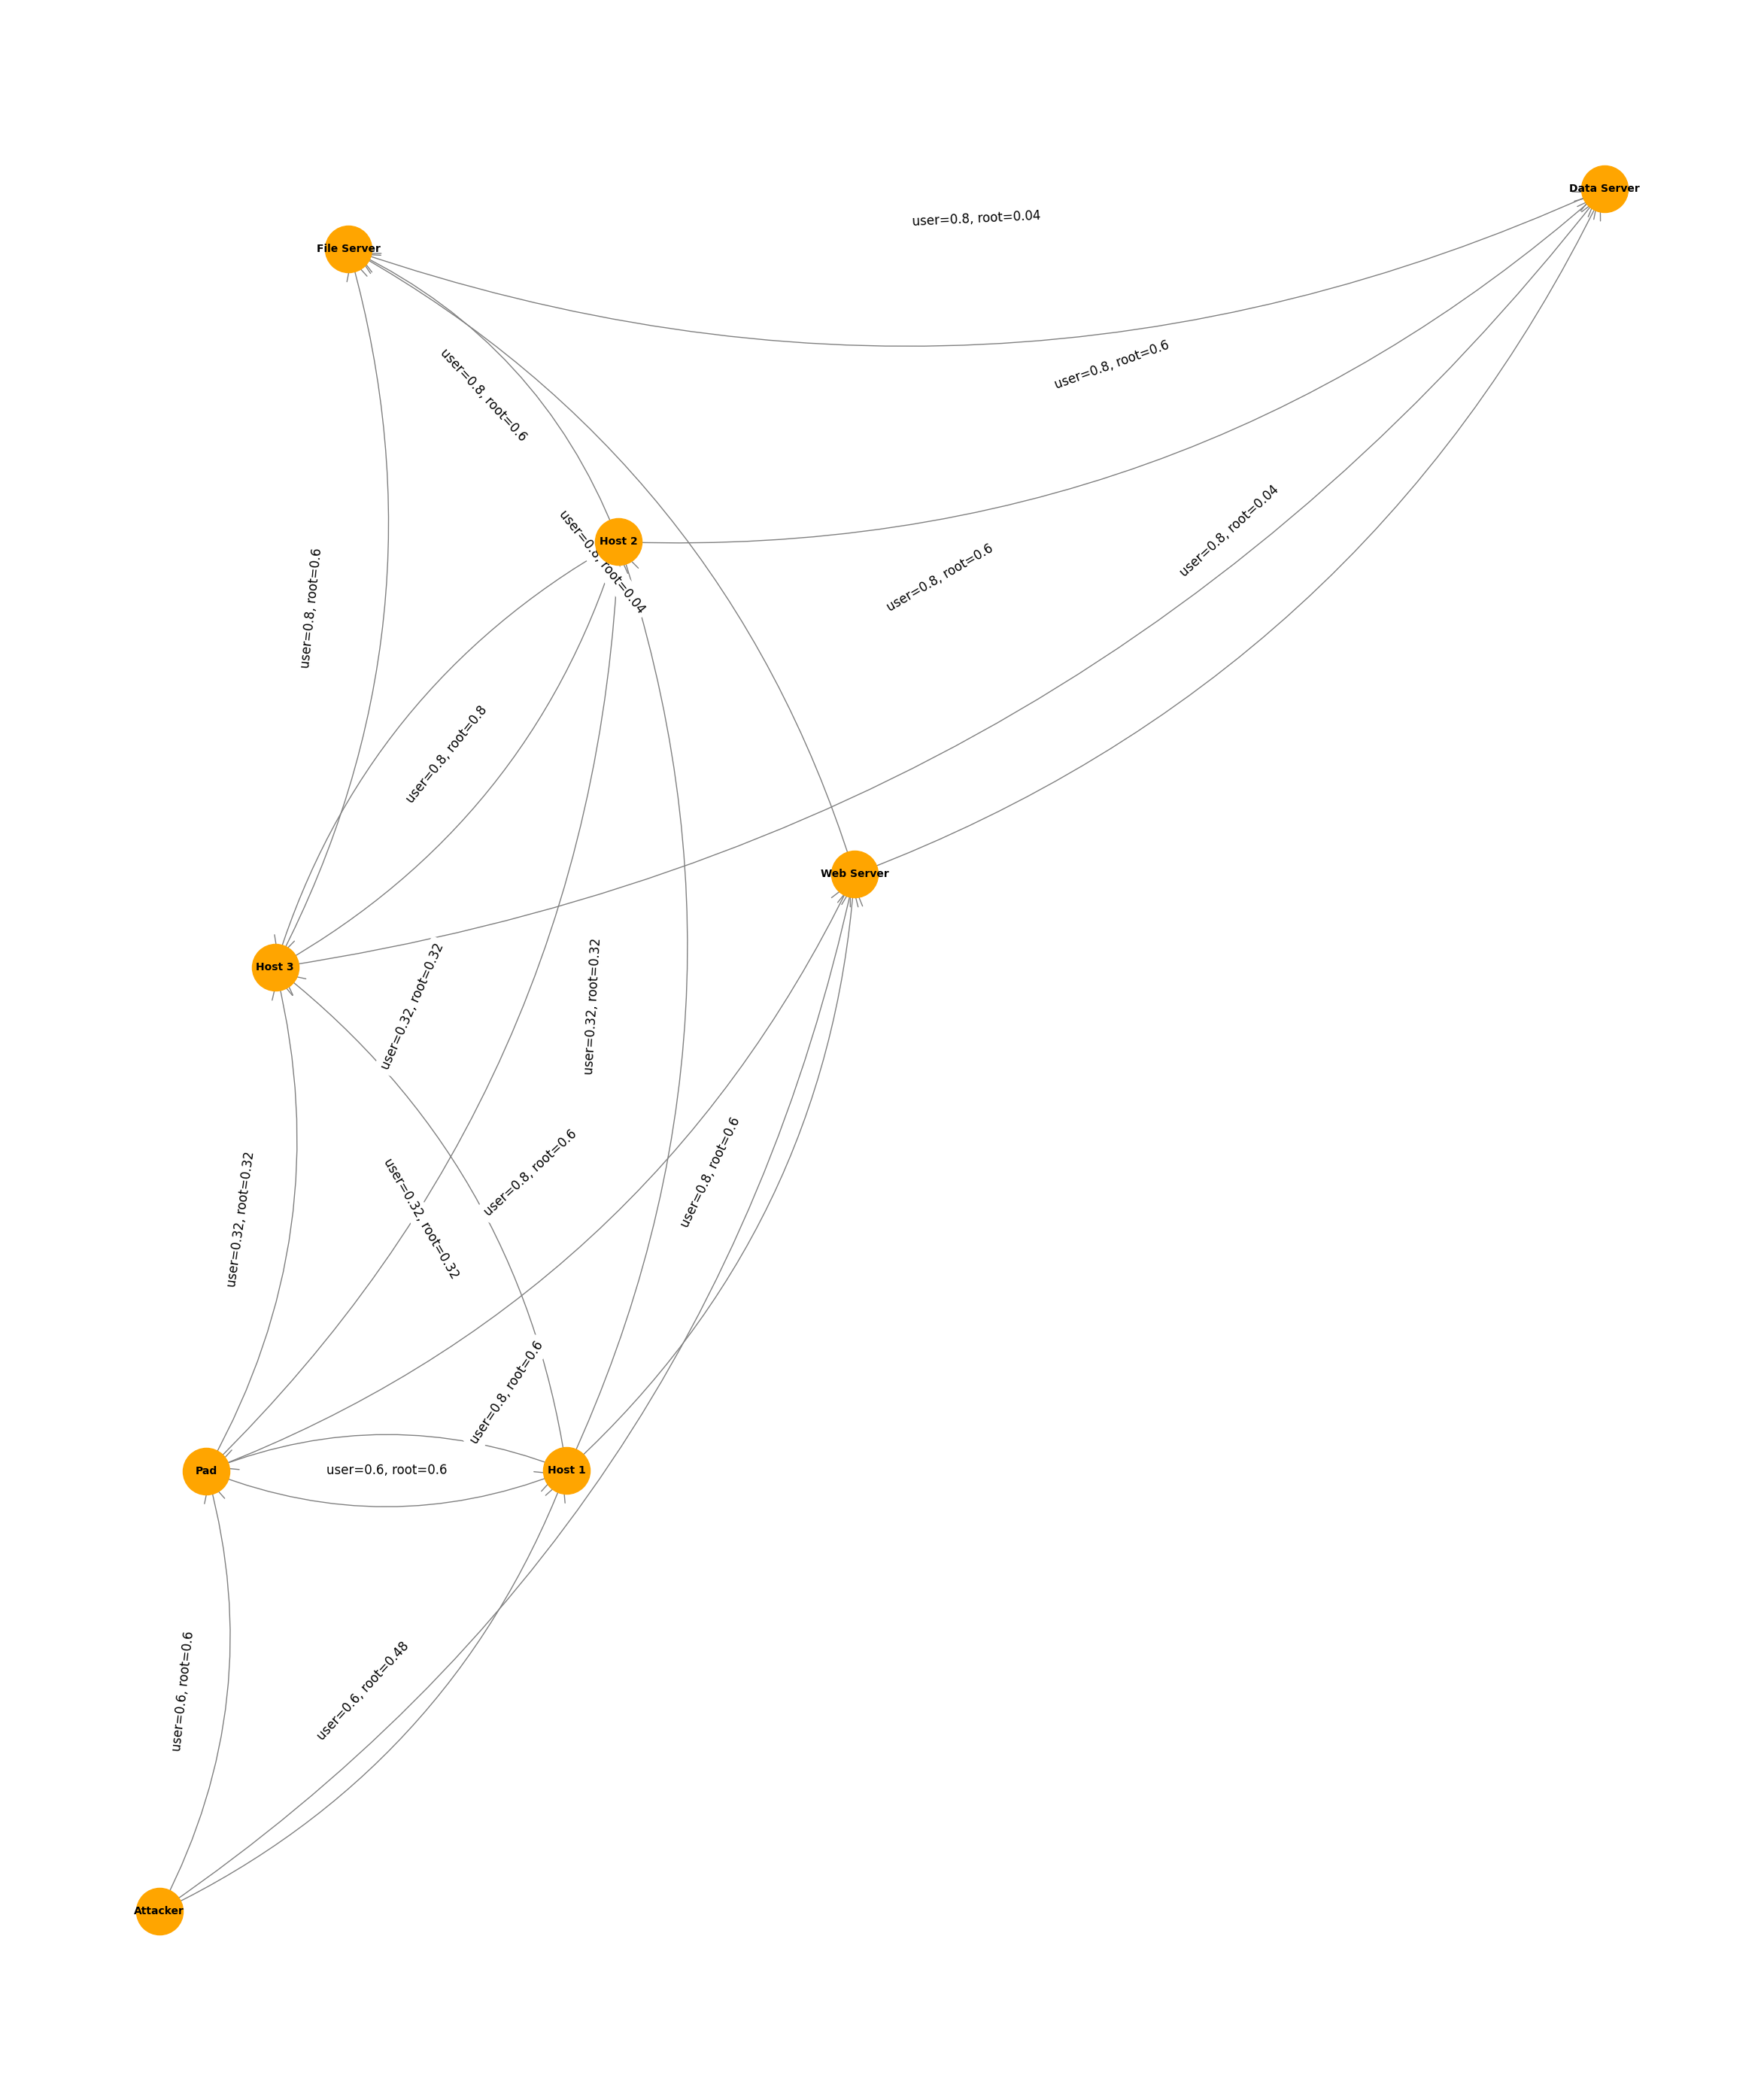

In [10]:
plt.figure(figsize=(30, 36))
pos = nx.spring_layout(G_original)

nx.draw_networkx_nodes(G_original, pos, node_color='orange', node_size=2000)
nx.draw_networkx_labels(G_original, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G_original, pos,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=50,
    connectionstyle='arc3,rad=0.2'
)

# Vẽ nhãn trên cạnh
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G_original.edges(data=True)}
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.show()


In [11]:
# Initialize environment and train
algo = global_weighted_random_attack
# algo = greedy_attack_priority_queue
env = NetworkSecurityEnv(G_original, algo)
num_episode = 10000
model = train_dqn(env, num_episode)

node_to_idx: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6}
state_size 7
action_space_size 105
Episode 1000, Total Reward: 170, Epsilon: 0.010, Defense Success Probability: 0.585%

Honeypot 0 -> Web Server
Honeypot 1 -> Host 1

['Attacker', 'Web Server', 'Honeypot {Web Server}']
Saved model with best DSP 585 at episode 1000 to ./Saved_Model/dqn_model.pth
Episode 2000, Total Reward: 176, Epsilon: 0.010, Defense Success Probability: 0.588%

Honeypot 0 -> Host 1
Honeypot 1 -> Pad

['Attacker', 'Host 1', 'Web Server', 'Honeypot {Host 1}']
Episode 3000, Total Reward: 206, Epsilon: 0.010, Defense Success Probability: 0.603%

Honeypot 0 -> Web Server
Honeypot 1 -> Pad

['Attacker', 'Web Server', 'Pad', 'Honeypot {Pad}']
Saved model with best DSP 603 at episode 3000 to ./Saved_Model/dqn_model.pth
Episode 4000, Total Reward: 282, Epsilon: 0.010, Defense Success Probability: 0.641%

Honeypot 0 -> Host 1
Honeypot 1 -> Web Server

['Attacker'

In [12]:
evaluate_model(model,env)

Episode: 1
['Attacker', 'Host 1', 'Host 3', 'Host 2', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 2
['Attacker', 'Web Server', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 3
['Attacker', 'Host 1', 'Host 2', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 4
['Attacker', 'Pad', 'Host 1', 'Host 2', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 5
['Attacker', 'Host 1', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 6
['Attacker', 'Pad', 'Host 1', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 1. 0. 0. 